# Задание 02

![](got.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
from math import ceil
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from ipywidgets import interact
%matplotlib inline

Будем изучать важность персонажей в книгах "A Song of Ice and Fire" (G.R.R. Martin). Два героя связаны ребром, если их имена появляются в тексте на расстоянии не более 15 слов в соответствующей книге. [Данные](https://github.com/mathbeveridge/asoiaf) находятся в открытом доступе для 5 книг.
Сеть -- взвешенная, вес ребра определяется числом взаимодействий (упоминаний в тексте).

In [2]:
# так как использую колаб, надо дать доступ к гугл-диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
book1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/asoiaf-book1-edges.csv')
book2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/asoiaf-book2-edges.csv')
book3 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/asoiaf-book3-edges.csv')
book4 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/asoiaf-book4-edges.csv')
book5 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/asoiaf-book5-edges.csv')

In [4]:
book5.head()

,Source,Target,Type,weight,book
0,Aegon-I-Targaryen,Daenerys-Targaryen,undirected,4,5
1,Aegon-Targaryen-(son-of-Rhaegar),Daenerys-Targaryen,undirected,11,5
2,Aegon-Targaryen-(son-of-Rhaegar),Elia-Martell,undirected,4,5
3,Aegon-Targaryen-(son-of-Rhaegar),Franklyn-Flowers,undirected,3,5
4,Aegon-Targaryen-(son-of-Rhaegar),Haldon,undirected,14,5


#### Постройте сеть персонажей по первой книге. 

In [5]:
G1 = nx.from_pandas_edgelist(book1,'Source', 'Target', edge_attr=True, create_using=nx.Graph())
G2 = nx.from_pandas_edgelist(book2,'Source', 'Target', edge_attr=True, create_using=nx.Graph())
G3 = nx.from_pandas_edgelist(book3,'Source', 'Target', edge_attr=True, create_using=nx.Graph())
G4 = nx.from_pandas_edgelist(book4,'Source', 'Target', edge_attr=True, create_using=nx.Graph())
G5 = nx.from_pandas_edgelist(book5,'Source', 'Target', edge_attr=True, create_using=nx.Graph())
graphs = [G1, G2, G3, G4, G5]

In [6]:
print(list(G1.edges(data=True))[16]) # ребро в сети

('Jaime-Lannister', 'Loras-Tyrell', {'Type': 'Undirected', 'weight': 3, 'book': 1})


#### 1.  Определите топ-10 персонажей по значению центральности по степени. Сколько среди них Старков? 

In [7]:
def getTop(G, centrality, n=10):
    return {k:v for k, v in sorted(centrality(G).items(), key=lambda x:x[-1], reverse=True)[:n]}

In [8]:
top10_degree_centrality = getTop(G1, nx.degree_centrality)

In [9]:
print('Количество Старков в топ-10: {}'.format(sum(['stark' in n.lower() for n,c 
                                                 in top10_degree_centrality.items()])))

Количество Старков в топ-10: 5


#### 2. Постройте функцию weighted_degree, учитывающую вес ребер: 

$$d_{w}^{i}=\sum_{j} w_{i,j},$$ где $w_{i,j}$ -- вес ребра $(i,j)$ ($w_{i,j}=0$, если нет ребра между вершинами $i$ и $j$).

#### Какое значение взвешенной степени у Eddard-Stark в сети?

In [10]:
def weighted_degree(G, node=None):
    if node:
        edges = G.edges(node)
        wd = sum(G.get_edge_data(u, v)['weight'] for u, v in edges)
        return wd
    else:
        return {n:weighted_degree(G, n) for n in G.nodes()}

In [11]:
print('Значение взвешенной степени у Eddard Stark: {}'.format(weighted_degree(G1, 'Eddard-Stark')))

Значение взвешенной степени у Eddard Stark: 1284


#### 3. Сколько персонажей из топ-10, определенным по центральности по степени (из вопроса 1) осталось в топ-10 по взвешенной степени ? 

In [12]:
top10_weighted_degree = getTop(G1, weighted_degree)

In [13]:
print('Ответ: {}'.format(len(set(top10_weighted_degree.keys()).intersection(top10_degree_centrality.keys()))))

Ответ: 8


#### 4.  Постройте топ-10 персонажей  по значению центральности по посредничеству. 
Сравните с топ-10 по степени и по взвешенной степени. 

In [14]:
top10_betweenness = getTop(G1, nx.betweenness_centrality)
top10_betweenness

{'Bran-Stark': 0.05579958811784442,
 'Catelyn-Stark': 0.1513952715347627,
 'Daenerys-Targaryen': 0.08627015537511595,
 'Drogo': 0.06481224290874964,
 'Eddard-Stark': 0.2696038913836117,
 'Jon-Snow': 0.17158135899829566,
 'Robb-Stark': 0.07298399629664767,
 'Robert-Baratheon': 0.21403028397371796,
 'Sansa-Stark': 0.03714483664326785,
 'Tyrion-Lannister': 0.1902124972697492}

#### Какой новый персонаж появился в рейтинге?

In [15]:
new_character = set(top10_betweenness.keys()).difference(top10_degree_centrality.keys()).\
                difference(top10_weighted_degree)
print('Ответ: {}'.format(new_character.pop()))

Ответ: Drogo


#### 5. Постройте топ-10 персонажей по значению центральности по посредничеству с учетом веса ребер. Кто теперь возглавляет список? 

In [16]:
weighted_betweenness_centrality = lambda G : nx.betweenness_centrality(G, weight='weight')

In [17]:
getTop(G1, weighted_betweenness_centrality)

{'Catelyn-Stark': 0.10169012330302643,
 'Drogo': 0.06894355184677767,
 'Eddard-Stark': 0.18703429235687297,
 'Jaime-Lannister': 0.07745109164464009,
 'Jon-Snow': 0.09027684366394043,
 'Jorah-Mormont': 0.0627085149665795,
 'Robb-Stark': 0.1024018949825402,
 'Robert-Baratheon': 0.23341885664466297,
 'Rodrik-Cassel': 0.07667992877670296,
 'Tyrion-Lannister': 0.15311225972516293}

In [18]:
print(getTop(G1, weighted_betweenness_centrality, 1))

{'Robert-Baratheon': 0.23341885664466297}


####  6. Постройте топ-10 по значению PageRank (по умолчанию учетываются веса ребер). Какое место в топе  занимает Daenerys-Targaryen?

In [19]:
top10_pagerank = getTop(G1, nx.pagerank)
top10_pagerank

{'Bran-Stark': 0.029770049939322262,
 'Catelyn-Stark': 0.03466661321136357,
 'Cersei-Lannister': 0.021620370924386133,
 'Daenerys-Targaryen': 0.02709861295221426,
 'Eddard-Stark': 0.07236162026570053,
 'Jon-Snow': 0.04770801150205559,
 'Robb-Stark': 0.029214217154195955,
 'Robert-Baratheon': 0.04849367196106828,
 'Sansa-Stark': 0.02694466267974005,
 'Tyrion-Lannister': 0.04367631315626212}

In [20]:
for e, n in enumerate(top10_pagerank, 1):
    if n=='Daenerys-Targaryen':
        print('Ответ: {}'.format(e))

Ответ: 8


#### 7. Постройте рейтинг по значению центральности по степени для персонажей 5-ой книги. Какую теперь наивысшую строчку рейтинга занимает персонаж из Дома Старков?  

In [21]:
stark5 = list(filter(lambda x : 'stark' in x[-1].lower(), 
                     enumerate(getTop(G5, nx.degree_centrality, n=None), 1)))

In [22]:
print('Ответ: {} place, {}'.format(*stark5[0]))

Ответ: 21 place, Eddard-Stark


#### 8.  Выберите персонажа и постройте график, показывающий как менялась его влиятельность от номера книги. 

In [23]:
def eigenvector_centrality(G):
    return nx.eigenvector_centrality(G, max_iter=500)

In [24]:
def getRank(G, centrality, character=None):
    if character:
        return list(filter(lambda x : x[-1]==character, enumerate(getTop(G, centrality, n=None), 1)))[0][0]
    else:
        return {k:i for i, (k, v) in enumerate(getTop(G, centrality, n=None).items(), 1)}

def getCharacterCentralities(G, character=None):
    if character:
        return {'degree' : getRank(G, nx.degree_centrality, character), 
                'weighted_degree' : getRank(G, weighted_degree, character), 
                'eigenvector' : getRank(G, eigenvector_centrality, character),
                'closeness' : getRank(G, nx.closeness_centrality, character),
                'betweenness' : getRank(G, nx.betweenness_centrality, character),
                'weighted_betweenness' : getRank(G, nx.betweenness_centrality, character),
                'pagerank' : getRank(G, nx.pagerank, character)}
    else:
        return {'degree' : getRank(G, nx.degree_centrality), 
                'weighted_degree' : getRank(G, weighted_degree), 
                'eigenvector' : getRank(G, eigenvector_centrality),
                'closeness' : getRank(G, nx.closeness_centrality),
                'betweenness' : getRank(G, nx.betweenness_centrality),
                'weighted_betweenness' : getRank(G, nx.betweenness_centrality),
                'pagerank' : getRank(G, nx.pagerank)}
def evolve(character, graphs, verbose=False):
    evolution = []
    if verbose:
        itGraphs = tqdm(graphs)
    else:
        itGraphs = graphs
    for G in itGraphs:
        evolution.append(getCharacterCentralities(G, character))
    return pd.DataFrame(evolution, index=[1, 2, 3, 4, 5])

def plotSignificance(character, graphs, verbose=False):
    df = evolve(character, graphs, verbose=verbose)*-1
    # specify seaborn palette for plot
    pal = sns.cubehelix_palette(start=2.8, rot=.1, n_colors=df.shape[-1], reverse=False)
    # plot
    plot = sns.lineplot(data=df, markers=True, dashes=False, palette=pal)
    name = " ".join(character.split('-'))
    title = 'Significance of {} through 5 books'.format(name)
    yticks = plt.yticks()[0]
    yticks = np.insert(arr=yticks[yticks < 0].astype(int), obj=0, values=[-1])
    plt.yticks(ticks=yticks, labels=yticks*-1)
    plt.xticks([1, 2, 3, 4, 5])
    plt.xlabel('Books')
    plt.ylabel('Centrality Rank')
    plot.set_title(title)
    return plot

def plotCharactersEvolution(characters : list, verbose=False):
    nrows = ceil(len(characters)/2)
    ncols = len(characters)%2+2
    fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6))

    for ax, character in zip(axis, characters):
        fig.add_subplot(ax, plotSignificance(character, graphs, verbose=verbose))

    plt.show()

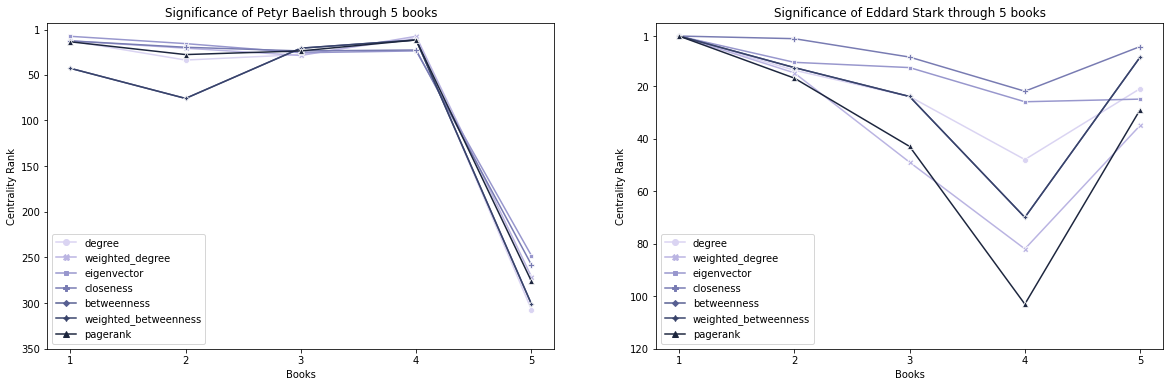

In [25]:
plotCharactersEvolution(characters=['Eddard-Stark', 'Petyr-Baelish'], verbose=False)

#### 9. Кто из персонажей самый влиятельный? 
Постройте сеть, объединяющую сети по всем книгам. Постройте таблицу наиболее влиятельных персонажей в зависимости от выбранной метрики.


In [26]:
metrics=['degree centrality','weighted degree','eigenvector centrality',
         'PageRank','closeness centrality','betweenness centrality']

df = pd.DataFrame(columns=['centrality metrics', 'character'], index=list(np.arange(1,len(metrics)+1)))
df['centrality metrics'] = metrics

In [27]:
grouped = pd.concat([book1, book2, book3, book4, book5], axis=0).groupby(['Source', 'Target'])['weight'].sum()
edges = np.array([np.array(pair) for pair in grouped.index.to_numpy()])
books = pd.DataFrame(data={'Source' : edges[:,0], 'Target' : edges[:, 1], 
                          'weight' : grouped.values, 'type' : ['Undirected']*grouped.shape[0]})

G = nx.from_pandas_edgelist(books, 'Source', 'Target', edge_attr=True, create_using=nx.Graph())

In [28]:
totalCentralities = getCharacterCentralities(G)
df = pd.DataFrame(totalCentralities)

In [29]:
df.index = df.index.map(lambda x : ' '.join(x.split('-')))

In [30]:
@interact
def showTop10(col=df.columns, topn=(1, 30)):
    def highlight_cols(s):
        color = sns.cubehelix_palette(start=2.8, rot=.1, n_colors=20).as_hex()[df.columns.get_loc(col)]
        return 'background-color: %s' % color
    return df.sort_values(by=col, ascending=True).head(topn).style.\
           applymap(highlight_cols, subset=pd.IndexSlice[:, [col]])

interactive(children=(Dropdown(description='col', options=('degree', 'weighted_degree', 'eigenvector', 'closen…